# Psience Examples

This is a hopefully growing set of examples of what can be done with Psience. The examples will mostly be self-contained(?) and might include some degree of exploration/development ideas. At a minimum, they should complement the unit tests to provide a starting point for working with the libraries.

## Configure Examples Environment

In [2]:
import sys, os, numpy as np, scipy, json
import McUtils.Plots as plt
from McUtils.Data import AtomData, UnitsData
import McUtils.Numputils as nput
from Psience.Molecools import Molecule
import McUtils.Jupyter as interactive

np.set_printoptions(linewidth=1e8, suppress=True)

TestManager = interactive.ExamplesManager("Psience")
Projects = interactive.ExamplesManager(os.path.expanduser("~/Documents/Postdoc/Projects/"), data_path=[])

# Plotting Examples

In [1]:
from McUtils.Jupyter import ModuleReloader
ModuleReloader("McUtils.Plots").reload()
ModuleReloader("McUtils.Jupyter").reload()
import McUtils.Plots as plt


KeyboardInterrupt



### Animated 2D plots with Matplotlib

In [ ]:
grids = [
    np.meshgrid(
        np.linspace(r, r+2*np.pi, 250),
        np.linspace(-r, -r+2*np.pi, 250),
        indexing='ij'
    )
    for r in np.linspace(0, np.pi, 10)
]
frame_data = [
    np.cos(g[0]) * np.sin(g[1])
    for g in grids
]


fig = plt.ArrayPlot(frame_data[0], frame=[[None, None], [None, None]])
frames = [
    plt.ArrayPlot(frame, figure=fig)
    for frame in frame_data[1:]
]
fig.animate_frames(frames)

### Manual X3D Visualizations

In [ ]:
from McUtils.Jupyter import X3DHTML, JHTML

JHTML.Figure(
    JHTML.Script(src='http://www.x3dom.org/download/x3dom.js'),
    JHTML.Link(rel='stylesheet', href='http://www.x3dom.org/download/x3dom.css'),
    X3DHTML.X3D(
        X3DHTML.Scene(
            JHTML.Input(type="range", value="0", min="0", max="1", step="1", cls="slider",
                        oninput="""document.getElementById("animation-frames").setAttribute("whichChoice", this.value)"""),
            X3DHTML.Switch(
                X3DHTML.Shape(
                    X3DHTML.Appearance(X3DHTML.Material(diffuseColor='red')),
                    X3DHTML.Sphere()
                ),
                X3DHTML.Shape(
                    X3DHTML.Appearance(X3DHTML.Material(diffuseColor='blue')),
                    X3DHTML.Sphere()
                ),
                whichChoice="0",
                id="animation-frames"
            )
            
        )
    ),
    width='500px',
    height='500px'
)

# VPT Examples

In [2]:
from Psience.VPT2 import *

### test_HOHAnalytic

In [5]:
file_name = "HOH_freq.fchk"
runner, states = AnalyticVPTRunner.construct(
    TestManager.test_data(file_name),
    [[
        0,
        [[0, 0, 1]]
    ]],
    # expressions_file=os.path.expanduser("~/Desktop/exprs.hdf5")
)
classic, _ = runner.construct_classic_runner(states)
mat_wfns = classic.print_tables()
atp_corrs = runner.run_VPT(states)

>>------------------------- calculating G-matrix derivatives -------------------------
:: took 0.000s...
>>--------------------------------------------------<<
>>------------------------- calculating potential derivatives -------------------------
:: prepping grad...
:: Cartesian transformation...
:: handling mixed derivative symmetry (MixedDerivativeHandlingModes.Analytical)...
:: checking Hessian...
:: took 0.015s...
>>--------------------------------------------------<<
>>------------------------- calculating dipole derivatives -------------------------
:: took 0.008s
>>--------------------------------------------------<<
>>------------------------- Computing PT corrections: -------------------------
:: states: 2
:: order: 2
:: expansion order: 2
::> getting representations
  > trying to load from checkpoint...
  > failed to load, building instead...
  ::> getting basis
    > trying to load from checkpoint...
    > fail to load, building instead...
    > getting states for H(1)|n(0)

### test_AnalyticWFC

In [6]:
file_name = "OCHH_freq.fchk"
AnalyticVPTRunner.run_simple(
    TestManager.test_data(file_name),
    [
        [
            0,
            [
                [0, 0, 0, 0, 0, 1],
                [0, 1, 0, 1, 0, 0],
                [0, 0, 0, 1, 1, 0],
                [0, 0, 0, 0, 1, 0],
            ],
        ],
        [
            [0, 0, 0, 0, 1, 0],
            [
                [0, 0, 0, 0, 1, 1],
                [0, 1, 0, 1, 1, 0]
            ]
        ]
    ],
    degeneracy_specs='auto',
    handle_degeneracies=True
)

>>------------------------- calculating G-matrix derivatives -------------------------
:: took 0.000s...
>>--------------------------------------------------<<
>>------------------------- calculating potential derivatives -------------------------
:: prepping grad...
:: Cartesian transformation...
:: handling mixed derivative symmetry (MixedDerivativeHandlingModes.Analytical)...
:: checking Hessian...
:: took 0.019s...
>>--------------------------------------------------<<
>>------------------------- calculating dipole derivatives -------------------------
:: took 0.013s
>>--------------------------------------------------<<
>>------------------------- Getting corrections at order 0 -------------------------
::> Building evaluator W[0][()]
  > took 0.000s
<::
::> evaluating...
  > took 0.000s
<::
>>--------------------------------------------------<<
>>------------------------- Getting corrections at order 0 -------------------------
::> Building evaluator W[0][(1, -1)]
  > took 0.000s

AnalyticPerturbationTheoryCorrections(states=BasisStateSpace(nstates=7, basis=HOBasis(dim=6)), state_lists=[[[[0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 1], [0, 1, 0, 1, 0, 0], [0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 1, 0]]], [[[0, 0, 0, 0, 1, 0]], [[0, 0, 0, 0, 1, 1], [0, 1, 0, 1, 1, 0]]]], _energies=array([0.02636274, 0.03934586, 0.03921411, 0.05172128, 0.04691512, 0.0398846 , 0.05255284]), _transition_moments=[[array([[ 0.        ,  0.        ,  0.        , -0.00000002]]), array([[0., 0.]])], [array([[-0.03782846, -0.0306695 , -0.        , -0.00000201]]), array([[-0.05043127, -0.01788934]])], [array([[ 0.00000247, -0.000002  ,  0.00498506, -0.0375401 ]]), array([[-0.00000037, -0.00000344]])]], _spectra=[[<Psience.Psience.Spectra.BaseSpectrum.DiscreteSpectrum object at 0x7fef252d5a00>], [<Psience.Psience.Spectra.BaseSpectrum.DiscreteSpectrum object at 0x7fef252fc550>]], _deperturbed_energies=array([0.02636274, 0.03956124, 0.03921411, 0.05181577, 0.04691512, 0.03966922, 0.05245835]), _deperturbed

### test_OCHHMultiple

Run starting from multiple initial states with automatic degeneracy handling

In [7]:
file_name = "OCHH_freq.fchk"
runner, states = AnalyticVPTRunner.construct(
    TestManager.test_data(file_name),
    [
        [
            0,
            [
                [0, 0, 0, 0, 0, 1],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 2, 0, 0]
            ],
        ],
        [
            [
                [0, 0, 0, 0, 0, 1],
            ],
            [
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 2, 0, 0]
            ],
        ]
    ],
    degeneracy_specs='auto'
    # degeneracy_specs=[
    #             [[0, 0, 0, 0, 0, 1], [0, 1, 0, 1, 0, 0]]
    #         ],
    # degeneracy_specs={
    #     'polyads': [
    #         [
    #             [0, 0, 0, 0, 0, 1],
    #             [0, 0, 0, 0, 1, 0]
    #         ],
    #         [
    #             [0, 0, 0, 0, 0, 1],
    #             [0, 1, 0, 1, 0, 0]
    #         ]
    #     ]
    # }
)
classic, _ = runner.construct_classic_runner(states,
                                             zero_element_warning=False
                                             )
classic.print_tables()
runner.run_VPT(states)

>>------------------------- calculating G-matrix derivatives -------------------------
:: took 0.000s...
>>--------------------------------------------------<<
>>------------------------- calculating potential derivatives -------------------------
:: prepping grad...
:: Cartesian transformation...
:: handling mixed derivative symmetry (MixedDerivativeHandlingModes.Analytical)...
:: checking Hessian...
:: took 0.018s...
>>--------------------------------------------------<<
>>------------------------- calculating dipole derivatives -------------------------
:: took 0.013s
>>--------------------------------------------------<<
>>------------------------- Getting corrections at order 0 -------------------------
>>------------------------- Building evaluator W[0][()] -------------------------
:: took 0.000s
>>--------------------------------------------------<<
::> evaluating...
  > took 0.000s
<::
>>--------------------------------------------------<<
>>------------------------- Getting c

AnalyticPerturbationTheoryCorrections(states=BasisStateSpace(nstates=5, basis=HOBasis(dim=6)), state_lists=[[[[0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0], [0, 0, 0, 2, 0, 0], [0, 1, 0, 1, 0, 0]]], [[[0, 0, 0, 0, 0, 1], [0, 1, 0, 1, 0, 0]], [[0, 0, 0, 0, 1, 0], [0, 0, 0, 2, 0, 0]]]], _energies=array([0.02636274, 0.03934586, 0.03921411, 0.04172755, 0.0398846 ]), _transition_moments=[[array([[ 0.        , -0.00000002, -0.        ,  0.        ]]), array([[-0.,  0.],
       [ 0.,  0.]])], [array([[-0.03782846, -0.00000201,  0.        , -0.0306695 ]]), array([[-0.01743934, -0.00333539],
       [-0.01342639, -0.00059361]])], [array([[ 0.00000247, -0.0375401 , -0.01037231, -0.000002  ]]), array([[ 0.00000104, -0.00000004],
       [-0.00000127,  0.00000004]])]], _spectra=[[<Psience.Psience.Spectra.BaseSpectrum.DiscreteSpectrum object at 0x7fef24604bb0>], [<Psience.Psience.Spectra.BaseSpectrum.DiscreteSpectrum object at 0x7fef25ef5790>, <Psience.Psience.Spectra.BaseSpectrum.Disc

# Molecule Examples

### Generate From SMILES with RDKit

In [ ]:
ccc = Molecule.from_string("CCC", "smi", 
                           add_implicit_hydrogens=True,
                           internals='auto'
                          )
ccc

### Import from MOL file with RDKit

In [ ]:
benzene = Molecule.from_file(
    TestManager.test_data('benzene.sdf'),
    internals={'primitives':'auto', 'relocalize':False}
)
benzene

Visualize the transformation between primitive internals and relocalized redundant internals

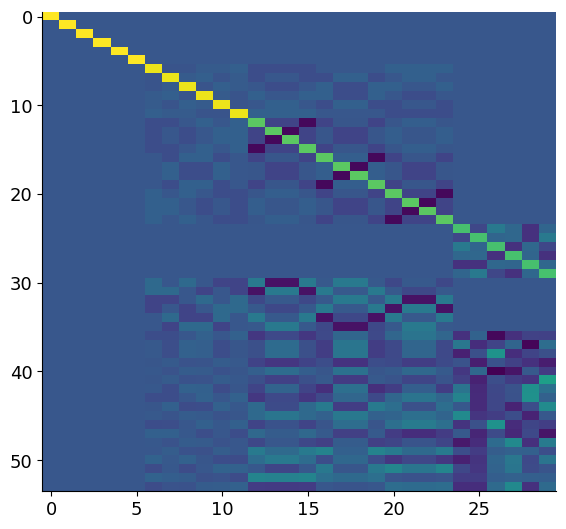

In [927]:
red_tf = benzene.internal_coordinates.converter_options['redundant_transformation']
plt.ArrayPlot(red_tf)

Visualize the first element of the delocalized block, using JSMol

In [ ]:
benzene.animate_coordinate(12, mode='jsmol')

## Import from FChk file

In [ ]:
nh3 = Molecule.from_file(
    TestManager.test_data("nh3.fchk"),
    internals=[
        [0, -1, -1, -1],
        [1,  0, -1, -1],
        [2,  0,  1, -1],
        [3,  0,  1,  2]
    ]
)
nh3

#### Animate Dihedral

It's so common to want to animate a given coordinate that I just added in a bespoke function for it...

In [ ]:
# I extracted a nice default viewmatrix from the X3D HTML element
vs = "{\"_00\":-0.9998172405453938,\"_01\":0.018742171764957148,\"_02\":-0.0037704781839175533,\"_03\":1.4745149545802857e-17,\"_10\":-0.003051418775696821,\"_11\":-0.35114503482210363,\"_12\":-0.9363161076064184,\"_13\":1.8034076836037622e-15,\"_20\":-0.01887258200824471,\"_21\":-0.9361334816773265,\"_22\":0.35113804996187,\"_23\":-5.482585044070595,\"_30\":0,\"_31\":0,\"_32\":0,\"_33\":0.9999999999999998}"
viewpoint = parse_x3d_view_matrix(vs)

nh3.animate_coordinate(5, view_settings=viewpoint)

##### More Control

In [ ]:
coord_expansion = nh3.get_cartesians_by_internals(2, strip_embedding=True)

geoms = nh3.get_scan_coordinates(
    [[-.3, .3, 10]],
    which=[5],
    coordinate_expansion=coord_expansion
)
geoms = np.concatenate([geoms, np.flip(geoms, axis=0)], axis=0)

# I extracted a nice default viewmatrix from the X3D HTML element
vs = "{\"_00\":-0.9998172405453938,\"_01\":0.018742171764957148,\"_02\":-0.0037704781839175533,\"_03\":1.4745149545802857e-17,\"_10\":-0.003051418775696821,\"_11\":-0.35114503482210363,\"_12\":-0.9363161076064184,\"_13\":1.8034076836037622e-15,\"_20\":-0.01887258200824471,\"_21\":-0.9361334816773265,\"_22\":0.35113804996187,\"_23\":-5.482585044070595,\"_30\":0,\"_31\":0,\"_32\":0,\"_33\":0.9999999999999998}"
viewpoint = parse_x3d_view_matrix(vs)

nh3.plot(geoms, view_settings=viewpoint, return_objects=False)

# DVRs

In [7]:
from Psience.DVR import *

### 1D

>>------------------------- Running DVR -------------------------
:: RingDVR((0, 6.283185307179586), pts=101, pot=<ufunc 'cos'>)
:: g: None
:: mass: 5
:: g_deriv: None
:: domain: (0, 6.283185307179586)
:: divs: 101
:: potential_function: <ufunc 'cos'>
::> constructing grid
<::
::> constructing potential matrix
  > evaluating potential function over grid
<::
::> constructing kinetic matrix
<::
::> building Hamiltonian
<::
::> evaluating wavefunctions
  ::> diagonalizing Hamiltonian
    > dimension=(101, 101)
    > density=100.000%
    > mode=None
  <::
<::
>>--------------------------------------------------<<


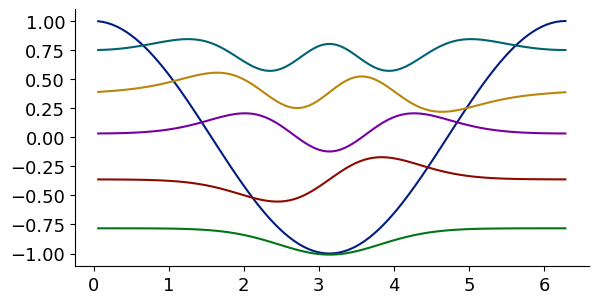

In [31]:
res = DVR(
    potential_function=np.cos,
    domain=(0, 2 * np.pi),
    divs=101,
    mass=5
).run()

fig = res.plot_potential()
res.wavefunctions[:5].plot(figure=fig, aspect_ratio=.5)
fig

## 2D

>>------------------------- Running DVR -------------------------
:: DirectProductDVR([RingDVR((0, 6.283185307179586), pts=51, pot=None), RingDVR((0, 6.283185307179586), pts=61, pot=None)], pot=<function <lambda> at 0x7fea34555310>)
:: g: None
:: mass: [5, 5]
:: g_deriv: [None, None]
:: domain: [(0, 6.283185307179586), (0, 6.283185307179586)]
:: divs: [51, 61]
:: potential_function: <function <lambda> at 0x7fea34555310>
::> constructing grid
<::
::> constructing potential matrix
  > evaluating potential function over grid
<::
::> constructing kinetic matrix
  > no kinetic coupling
<::
::> building Hamiltonian
<::
::> evaluating wavefunctions
  ::> diagonalizing Hamiltonian
    > dimension=(3111, 3111)
    > density=3.568%
    > mode=None
  <::
<::
>>--------------------------------------------------<<


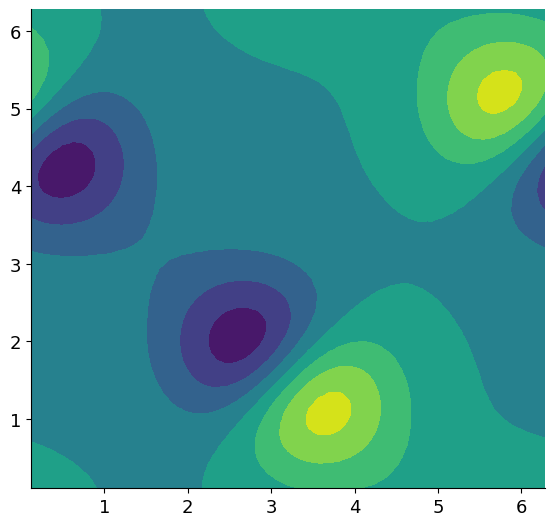

In [35]:
res = DVR(
    potential_function=lambda pts: np.cos(pts[:, 0]) * np.sin(pts[:, 1]),
    domain=[
        (0, 2 * np.pi),
        (0, 2 * np.pi),
    ],
    divs=[51, 61],
    mass=[5, 5]
).run()

# fig = res.plot_potential()
res.wavefunctions[2].plot()
# fig

## Molecular Systems

In [37]:
from McUtils.Zachary import Interpolator

In [80]:
TestManager.load_module("Psience.DVR")
TestManager.import_from("Psience.Molecools", "Molecule")

Psience.Psience.Molecools.Molecule.Molecule

1620.8110909739974 1620.1332265126284


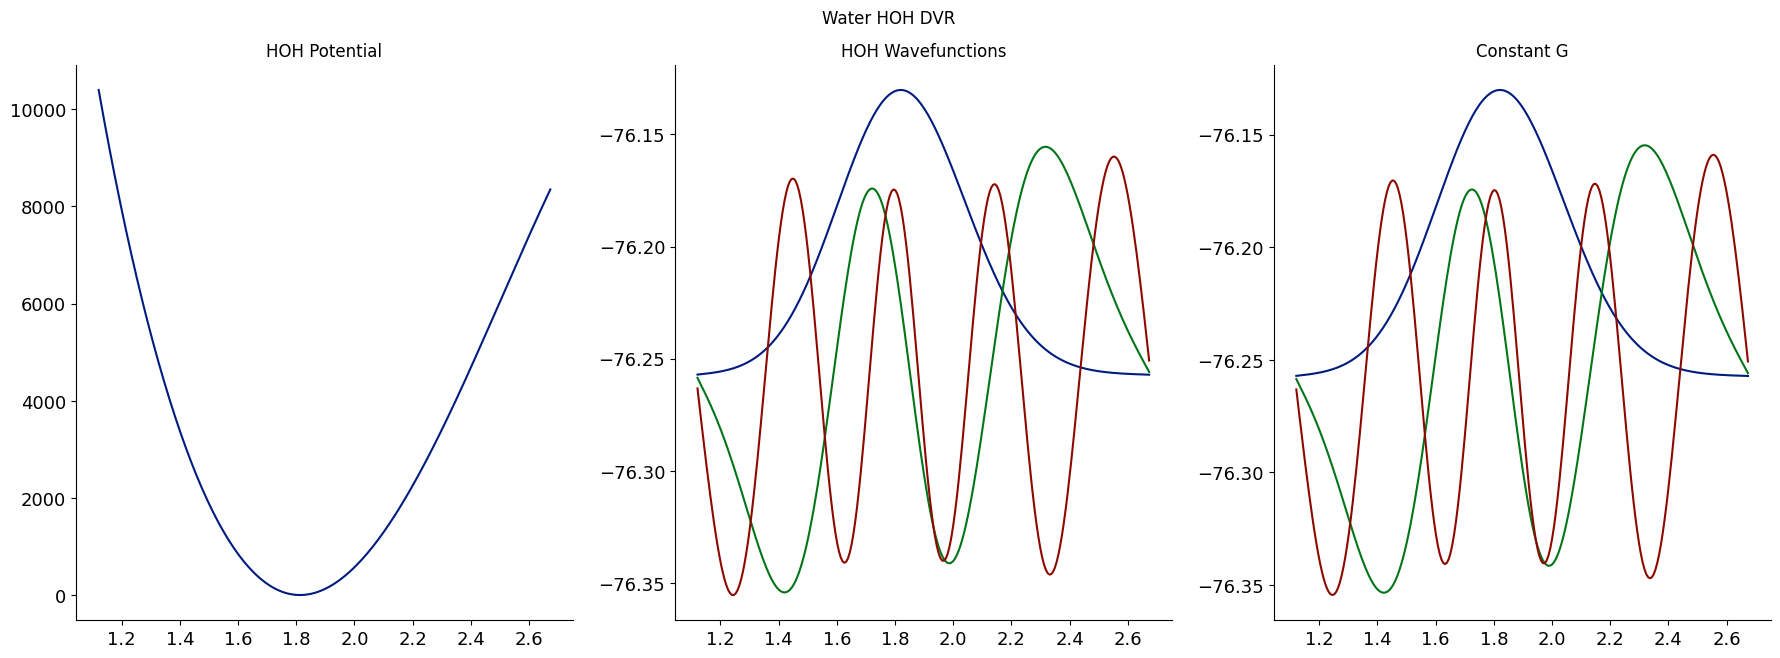

In [88]:
scan_coords = Molecule.from_file(
    TestManager.test_data("water_HOH_scan.log"),
    internals=[
        [0, -1, -1, -1],
        [1,  0, -1, -1],
        [2,  0,  1, -1]
    ]
)
# compute G-matrix in batch
XQ = scan_coords.get_internals_by_cartesians(1, strip_embedding=True)[0]
m = np.diag(np.repeat(1/np.sqrt(scan_coords.atomic_masses), 3))
B = np.tensordot(XQ, m, axes=[1, 0])
g = B @ np.moveaxis(B, 1, 2)

a_vals = scan_coords.bond_angle(1, 0, 2)

g_func = Interpolator(a_vals, g[:, 2, 2])
g_deriv = g_func.derivative(2)

# Get potential
scan_coords.potential_surface.surface_coords = [(1, 0, 2)]
pot = scan_coords.potential_surface.surface#(coordinates=((1, 0, 2),))
min_pos = np.argmin(pot.base.interp_data[1])
g_eq = g[min_pos][2, 2]

carts = CartesianDVR(domain=(np.min(a_vals), np.max(a_vals)), divs=251,
                     mass=1/g_eq,
                     potential_function=pot,
                     nodeless_ground_state=True
                     )
res_const = carts.run()

carts = CartesianDVR(domain=(np.min(a_vals), np.max(a_vals)),
                     divs=251,
                     g=g_func,
                     g_deriv=g_deriv,
                     potential_function=pot,
                     nodeless_ground_state=True
                     )
res = carts.run()

print(
    (res.wavefunctions.energies[1] - res.wavefunctions.energies[0])*UnitsData.convert("Hartrees", "Wavenumbers"),
    (res_const.wavefunctions.energies[1] - res_const.wavefunctions.energies[0])*UnitsData.convert("Hartrees", "Wavenumbers")
)

grid = plt.GraphicsGrid(nrows=1, ncols=3,
                        subimage_size=(400, 400),
                        spacings=[10, 0],
                        padding=[[50, 0], [50, 50]],
                        figure_label='Water HOH DVR'
                        )

res.plot_potential(figure=grid[0, 0], zero_shift=True, plot_units='wavenumbers'); grid[0, 0].plot_label = 'HOH Potential'
res.wavefunctions[(0, 3, 7),].plot(figure=grid[0, 1]); grid[0, 1].plot_label = 'HOH Wavefunctions'
res_const.wavefunctions[(0, 3, 7),].plot(figure=grid[0, 2]); grid[0, 2].plot_label = 'Constant G'
# wf_ploot = res.wavefunctions[(0, 3, 7),]
# wf_ploot.plot(figure=grid[0, 2]); grid[0, 2].plot_label ='HOH G-Matrix'

grid

## Specific Cases

### CartesianDVR to force 0 at boundary

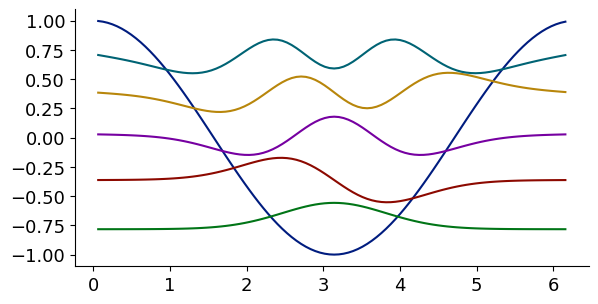

In [90]:
dvr_1D = CartesianDVR()
res = dvr_1D.run(potential_function=np.cos,
             domain=(0, 2 * np.pi),
             divs=101,
             mass=5
             )
fig = res.plot_potential()
res.wavefunctions[:5].plot(figure=fig, aspect_ratio=.5)
fig

### RingDVR for periodic boundary

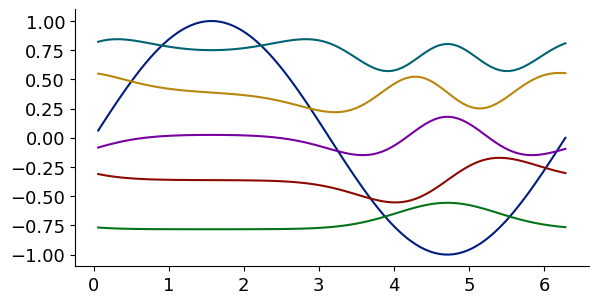

In [89]:
dvr_1D = RingDVR()
res = dvr_1D.run(potential_function=np.sin,
             domain=(0, 2 * np.pi),
             divs=101,
             mass=5
             )
fig = res.plot_potential()
res.wavefunctions[:5].plot(figure=fig, aspect_ratio=.5)
fig

# DGBs

In [3]:
from Psience.DGB import *

## Water Examples

### Water Model Constructor

In [2]:
def buildWaterModel(*,
                    oh_model=False,
                    atoms=None,
                    w=3869.47 * UnitsData.convert("Wavenumbers", "Hartrees"),
                    wx=84 * UnitsData.convert("Wavenumbers", "Hartrees"),
                    w2=3869.47 * UnitsData.convert("Wavenumbers", "Hartrees"),
                    wx2=84 * UnitsData.convert("Wavenumbers", "Hartrees"),
                    ka=1600 ** 2 / 150 * UnitsData.convert("Wavenumbers", "Hartrees"),
                    dudr1=None, dudr2=None, duda=None,
                    dipole=None,
                    dipole_magnitude=None,
                    dipole_direction='auto'
                    ):
    base_water = Molecule.from_file(
        TestManager.test_data('water_freq.fchk'),
        internals=[
            [0, -1, -1, -1],
            [1,  0, -1, -1],
            [2,  0,  1, -1],
        ]
    )

    if oh_model:
        w2 = None
        wx2 = None
        ka = None
        mol = Molecule(
            base_water.atoms[:2],
            # ['O', 'O'],
            base_water.coords[:2],
            internals=[[0, -1, -1, -1], [1, 0, -1, -1]]
        )#.get_embedded_molecule(load_properties=False)
    elif atoms is not None:
        mol = Molecule(
            atoms,
            # ['O', 'O'],
            base_water.coords,
            internals=[
                [0, -1, -1, -1],
                [1,  0, -1, -1],
                [2,  0,  1, -1],
            ]
        ).get_embedded_molecule(load_properties=False)
    else:
        mol = base_water.get_embedded_molecule(load_properties=False)

    r1 = 0
    r2 = 1
    a12 = 2
    potential_params = {}
    if wx is not None:
        potential_params[r1] = {'morse': {'w': w, 'wx': wx}}
    elif w is not None:
        potential_params[r1] = {'harmonic': {'k': w}}
    if wx2 is not None:
        potential_params[r2] = {'morse': {'w': w2, 'wx': wx2}}
    elif w2 is not None:
        potential_params[r2] = {'harmonic': {'k': w2}}
    elif w2 is not None:
        potential_params[r2] = {'harmonic': {'k': w2}}
    if ka is not None:
        potential_params[a12] = {'harmonic': {'k': ka}}

    if dipole is None and dudr1 is not None or dudr2 is not None or duda is not None:
        if oh_model:
            dipole = [
                {r1: {'linear': {'eq': 0, 'scaling': dudr1}}},
                0,
                0
            ]
        else:
            dipole = [
                {
                    (r1, a12): ({'linear': {'eq': 0, 'scaling': dudr1}}, {'sin': {'eq': 0}}),
                    (r2, a12): ({'linear': {'eq': 0, 'scaling': dudr2}}, {'sin': {'eq': 0, 'scaling': -1}})
                },
                {
                    (r1, a12): ({'linear': {'eq': 0, 'scaling': dudr1}}, {'cos': {'eq': 0, 'scaling': 1/2}}),
                    (r2, a12): ({'linear': {'eq': 0, 'scaling': dudr2}}, {'cos': {'eq': 0, 'scaling': 1/2}})
                },
                0
            ]

    # if dipole is not None:
    #     if isinstance(dipole, str) and dipole == 'auto':
    #         dipole_magnitude = 'auto'
    # elif dudr1 is not None or dudr2 is not None or duda is not None:
    #
    #     dipole_magnitude = {}
    #     if dudr1 is not None:
    #         dipole_magnitude[r1] = {'linear': {'eq': 0, 'scaling': dudr1}}
    #     if dudr2 is not None:
    #         dipole_magnitude[r2] = {'linear': {'eq': 0, 'scaling': dudr2}}
    #     if duda is not None:
    #         dipole_magnitude[a12] = {'linear': {'eq': 0, 'scaling': duda}}
    # if dipole_magnitude is not None:
    #     if isinstance(dipole_magnitude, str) and dipole_magnitude == 'auto':
    #         dipole_magnitude = {
    #             r1: {'linear': {'eq': 0, 'scaling': 1 / 5.5}},
    #             r2: {'linear': {'eq': 0, 'scaling': 1 / 5.5}}
    #         }
    #     if isinstance(dipole_direction, str) and dipole_direction == 'auto':
    #         if oh_model:
    #             dipole_direction = [
    #                 1,
    #                 0,
    #                 0
    #             ]
    #         else:
    #             dipole_direction = [
    #                 {
    #                     a12:{'sin': {'eq': 0}}
    #                 },
    #                 {
    #                     a12: {'cos': {'eq': 0}}
    #                 },
    #                 0
    #             ]
    #     dipole = [
    #         0
    #             if isinstance(d, int) and d == 0 else
    #         dipole_magnitude
    #             if isinstance(d, int) and d == 1 else
    #         cls.multiply_model_functions(dipole_magnitude, d)
    #         for d in dipole_direction
    #     ]

    return mol, mol.get_model(
        potential_params,
        dipole=dipole
    )

## 1D Stretch 

>>------------------------- optimizing using Gram-Schmidt -------------------------
::> Evaluating S matrix
  > getting 2628 overlap Gaussians over 1 chunks
  > evaluating 2628 overlaps
<::
:: pruning with pivoted Gram-Schmidt norm > 1e-08
:: pruned 46 Gaussians
>>--------------------------------------------------<<
---> 26
[[1.         0.4500123  0.53918222 0.29459682 0.15393416]
 [0.4500123  1.         0.06626295 0.02327446 0.00914194]
 [0.53918222 0.06626295 1.         0.89510718 0.68332796]
 [0.29459682 0.02327446 0.89510718 1.         0.92005656]
 [0.15393416 0.00914194 0.68332796 0.92005656 1.        ]]
>>------------------------- Evaluating kinetic energy matrix -------------------------
:: evaluating Watson diagonal momentum contribution
:: evaluating coriolis contribution
:: evaluating Watson term contribution
>>--------------------------------------------------<<
[[ 0.01758719 -0.0052767  -0.00186395 -0.00581817 -0.00523222]
 [-0.0052767   0.02257937 -0.00487756 -0.00228629 -

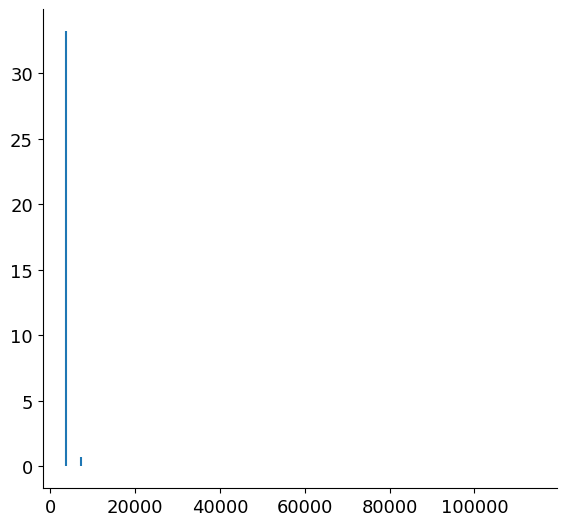

In [6]:
w2h = UnitsData.convert("Wavenumbers", "Hartrees")
mol, model = buildWaterModel(
    w2=None, wx2=None,
    ka=None,
    oh_model=True,
    dudr1=1 / 5.5,
    dudr2=None#1 / 5.5
    # dipole_direction=[1, 0, 0]
)

check_freqs = False
if check_freqs:
    freqs = model.normal_modes()[0]
    raise Exception(freqs * UnitsData.convert("Hartrees", "Wavenumbers"))

check_anh = False
if check_anh:
    model.run_VPT(order=2, states=5, degeneracy_specs='auto', logger=True)
    """
    ZPE: 1934.73500   1913.73500
    ============================================= IR Data ==============================================
    Initial State: 0 
                   Harmonic                  Anharmonic
    State   Frequency    Intensity       Frequency    Intensity
      1    3869.47000     33.99218      3701.47000     33.22606
      2    7738.94000      0.00000      7234.94000      0.68986
      3   11608.41000      0.00000     10600.41000      0.02926
      4   15477.88000      0.00000     13797.88000      0.00000
      5   19347.35000      0.00000     16827.35000      0.00000
    ====================================================================================================
    """
    raise Exception(...)

# mol.potential_derivatives = model.potential(mol.coords, deriv_order=2)[1:]
# raise Exception(mol.coords, mol.normal_modes.modes)

sim = model.setup_AIMD(
    initial_energies=[
        [ 3800 * 3 * w2h],
        [-3800 * 3 * w2h]
    ],
    timestep=10
)
sim.propagate(35)
coords = sim.extract_trajectory(flatten=True, embed=mol.coords)



cartesians = False
dgb = model.setup_DGB(
    np.round(coords, 8),
    optimize_centers=1e-8,
    # optimize_centers=False,
    alphas={'method':'virial', 'scaling':2},
    modes=None if cartesians else 'normal',
    cartesians=[0, 1] if cartesians else None,
    quadrature_degree=3,
    # expansion_degree=2,
    # pairwise_potential_functions={
    #     (0, 1): self.setupMorseFunction(model, 0, 1)
    #     # (0, 2): self.setupMorseFunction(model, 0, 2)
    # }
)

wfns, spec = DGBRunner.runDGB(dgb, mol,
            domain_padding=10,
            plot_spectrum=True,
            plot_wavefunctions=False#{'cartesians':[0, 1]} if not cartesians else True
            )
spec.plot()

### Full 3D Model

In [ ]:
mol, model = buildWaterModel(
    # w2=None, wx2=None,
    # ka=None,
    dudr1=1 / 5.5,
    dudr2=1 / 5.5
    # dipole_direction=[1, 0, 0]
)

check_freqs = False
if check_freqs:
    freqs = model.normal_modes()[0]
    raise Exception(freqs * UnitsData.convert("Hartrees", "Wavenumbers"))

check_anh = False
if check_anh:
    from Psience.VPT2 import VPTRunner

    VPTRunner.run_simple(
        [mol.atoms, mol.coords],
        potential_derivatives=model.potential(mol.coords, deriv_order=4)[1:],
        dipole_derivatives=model.dipole(mol.coords, deriv_order=3),
        order=2, states=3,
        logger=True,
        degeneracy_specs='auto',
        calculate_intensities=True,
        include_coriolis_coupling=True
    )

    """
      0 0 0    4680.66314                   4611.38521
                      Harmonic                  Anharmonic
    State       Frequency    Intensity       Frequency    Intensity
      0 0 1    3896.87028     64.98650      3719.85792     62.04864
      0 1 0    3843.25804      0.17386      3676.15022      0.13738
      1 0 0    1621.19796     64.86522      1603.43661     64.14564
      0 0 2    7793.74057      0.00000      7405.54785      0.00156
      0 2 0    7686.51607      0.00000      7216.32913      0.00897
      2 0 0    3242.39591      0.00000      3197.00895      0.07403
      0 1 1    7740.12832      0.00000      7229.92435      1.31011
      1 0 1    5518.06824      0.00000      5308.87368      0.09319
      1 1 0    5464.45599      0.00000      5278.21350      0.07390
      0 0 3   11690.61085      0.00000     10968.42588      0.00035
      0 3 0   11529.77411      0.00000     10889.98015      0.00002
      3 0 0    4863.59387      0.00000      4780.71702      0.02966
      0 1 2   11636.99860      0.00000     10585.27120      0.00057
      1 0 2    9414.93853      0.00000      8988.16177      0.00045
      0 2 1   11583.38636      0.00000     10587.47926      0.05388
      2 0 1    7139.26620      0.00000      6888.02518      0.00327
      1 2 0    9307.71403      0.00000      8809.00009      0.00197
      2 1 0    7085.65395      0.00000      6870.41251      0.00035
      1 1 1    9361.32628      0.00000      8817.56679      0.00646
      """
    raise Exception(...)

check_dvr = False
if check_dvr:
    raise ValueError("you don't want to rerun this")
    dvr = model.setup_DVR(
        domain=[[1, 4], [1, 4], [np.deg2rad(60), np.deg2rad(160)]],
        divs=[800, 800, 800], po_divs=[25, 25, 25],
        potential_optimize=True,
        logger=True
    )
    po_data = dvr.run()
    """
    :: PotentialOptimizedDVR([WavefunctionBasisDVR(None, pts=20, pot=None), WavefunctionBasisDVR(None, pts=20, pot=None), WavefunctionBasisDVR(None, pts=20, pot=None)], pot=SympyExpr(0.203038951525208*(1 - exp(-0.813301570558368*sqrt(2)*(r[1,2] - 1.8253409520594)))**2 + 0.203038951525208*(1 - exp(-0.813301570558368*sqrt(2)*(r[2,3] - 1.82534095205941)))**2 + 0.255579575354735*(0.551593470847119*a[1,2,3] - 1)**2))
    :: g: [[SympyExpr(0.0005786177281533848), SympyExpr(3.42971451934982e-5*cos(a[1,2,3])), SympyExpr(-3.42971451934982e-5*sin(a[1,2,3])/r[2,3])], [SympyExpr(3.42971451934982e-5*cos(a[1,2,3])), SympyExpr(0.0005786177281533848), SympyExpr(0.0)], [SympyExpr(-3.42971451934982e-5*sin(a[1,2,3])/r[2,3]), SympyExpr(0.0), SympyExpr(0.000578617728153385/r[2,3]**2 - 6.85942903869965e-5*cos(a[1,2,3])/(r[1,2]*r[2,3]) + 0.000578617728153385/r[1,2]**2)]]
    :: mass: [None, None, None]
    :: g_deriv: [SympyExpr(0.0), SympyExpr(0.0), SympyExpr(6.85942903869965e-5*cos(a[1,2,3])/(r[1,2]*r[2,3]))]
    :: domain: [[1, 4], [1, 4], [1.0471975511965976, 2.792526803190927]]
    :: divs: [800, 800, 800]
    :: potential_function: SympyExpr(0.203038951525208*(1 - exp(-0.813301570558368*sqrt(2)*(r[1,2] - 1.8253409520594)))**2 + 0.203038951525208*(1 - exp(-0.813301570558368*sqrt(2)*(r[2,3] - 1.82534095205941)))**2 + 0.255579575354735*(0.551593470847119*a[1,2,3] - 1)**2)
    ::> constructing grid
    <::
    ::> constructing potential matrix
      > evaluating potential function over grid
    <::
    ::> constructing kinetic matrix
      > evaluating kinetic coupling
    <::
    ::> building Hamiltonian
    <::
    ::> evaluating wavefunctions
      ::> diagonalizing Hamiltonian
        > dimension=(8000, 8000)
        > density=9.750%
        > mode=None
      <::
    <::
    >>--------------------------------------------------<<
    ERROR

    ======================================================================
    ERROR: test_ModelPotentialAIMD (tests.DGBTests.DGBTests)
    ----------------------------------------------------------------------
    Traceback (most recent call last):
      File "/Users/Mark/Documents/UW/Research/Development/Peeves/Peeves/TestUtils.py", line 501, in Debug
        return fn(*args, **kwargs)
      File "/Users/Mark/Documents/UW/Research/Development/Psience/ci/tests/DGBTests.py", line 1040, in test_ModelPotentialAIMD
        raise Exception(po_data.wavefunctions.frequencies()*UnitsData.hartrees_to_wavenumbers)
    Exception: (
        6234.520135705428, 
        array([ 
            1603.52651473,  3197.92783543,  
            3677.14362091,  3719.74235567,  
            4791.35107014,  5281.20835861,  5308.52076799,  
            6402.00507514,  6876.02718339,  6885.85546794,  
            7220.93261924,  7232.7182684 ,  7405.52232462,  
            8049.27247436,  8459.98906896,  8479.50398517,  
            8821.70119285,  8825.8627132 ,  8988.5644022 ,  
            9731.71367219, 10046.96812294, 10127.39430738, 
            10403.06169691, 10407.06227839
            ]))
     """
    raise Exception(
        po_data.wavefunctions.energies[1] * UnitsData.hartrees_to_wavenumbers,
        po_data.wavefunctions.frequencies() * UnitsData.hartrees_to_wavenumbers
    )

# mol.potential_derivatives = model.potential(mol.coords, deriv_order=2)[1:]
# raise Exception(mol.coords, mol.normal_modes.modes)

bend, symm, asymm = model.normal_modes()[0]
init_e = np.array([
        [-bend,     0,       0 ],
        [ bend,     0,       0 ],
        [    0,  -symm,       0 ],
        # [    0,   symm,       0 ],
        [    0,     0,   asymm ],
        # [ bend,  symm,       0 ],
        # [-bend,  symm,       0 ],
        # [ bend,     0,   asymm ],
        # [-bend,     0,   asymm ],
        # [    0,  symm,   asymm ],
        # [ bend,  symm,   asymm ],
        # [-bend,  symm,   asymm ],
    ])
sim = model.setup_AIMD(
    initial_energies=init_e * 1,
    timestep=25,
    track_velocities=True
)
sim.propagate(100)


# coords = sim.extract_trajectory(flatten=True, embed=mol.coords)
coords, velocities = sim.extract_trajectory(flatten=True, embed=mol.coords)
coords = coords[len(init_e) - 1:]
velocities = velocities[len(init_e) - 1:]
momenta = 150 * velocities * mol.masses[np.newaxis, :, np.newaxis]
virial_scaling = 1.2
# all_pots = model.potential(coords)
# virial_scaling = 1 + (all_pots - np.min(all_pots)) / (np.max(all_pots) - np.min(all_pots))
# virial_scaling = virial_scaling[:, np.newaxis]
pruning_energy = 3600 / UnitsData.hartrees_to_wavenumbers

mol.potential_derivatives = model.potential(mol.coords, deriv_order=2)[1:]
modes = mol.normal_modes.modes.basis.to_new_modes()
emb_coords = modes.embed_coords(coords)
new_emb = emb_coords * np.array([1, 1, -1])[np.newaxis, :]
new_coords = modes.unembed_coords(new_emb)

cartesians = False
use_interpolation = True
plot_interpolation_error = True
use_quadrature = False
permute_coords = True
if use_interpolation:
    if permute_coords:
        interp_coords = np.concatenate([coords, new_coords], axis=0)
    else:
        interp_coords = coords
    potential_data = {
        'centers':interp_coords,
        'values':model.potential(interp_coords, deriv_order=2)
    }
else:
    potential_data = None
use_momenta = True
use_pairwise = True

if use_quadrature and use_interpolation:
    raise ValueError("don't use interpolation with quadrature...")

# plot_wfns = {'modes':[2, 1]}
plot_wfns = {'cartesians':[0, 1], 'num':10}

dgb = model.setup_DGB(
    coords,
    potential_function=potential_data,
    # optimize_centers=False,
    optimize_centers=[
        {
            'method': 'energy-cutoff',
            'cutoff': pruning_energy
        } if pruning_energy is not None else None,
        1e-14
    ],
    alphas={'method':'virial', 'scaling':virial_scaling},
    modes=None if cartesians else 'normal',
    cartesians=[0, 1] if cartesians else None,
    quadrature_degree=3
    , expansion_degree=2 if not use_quadrature else None
    , pairwise_potential_functions={
        (0, 1):DGBRunner.setupMorseFunction(model, 0, 1),
        (0, 2):DGBRunner.setupMorseFunction(model, 0, 2)
    } if use_pairwise and not use_quadrature else None
    , transformations='diag'
    , momenta=momenta if use_momenta else None
)


plot_gaussians = False
if plot_gaussians:
    DGBRunner.plot_gaussians(
        dgb, mol,
        cartesians=True,
        coordinate_sel=[0, 1]
    )
    raise Exception(...)

if use_interpolation and plot_interpolation_error:
    DGBRunner.plot_interpolation_error(dgb, model.potential)
    raise Exception(...)
    
DGBRunner.runDGB(dgb, mol,
            similarity_cutoff=.9,
            # similarity_chunk_size=5,
            # vmin=-.05,
            # vmax=.05,
            # domain=[[-2, 2], [-2, 2]],
            # plot_wavefunctions=False,
            plot_centers=True,
            plot_spectrum=False,
            plot_wavefunctions=plot_wfns,
            # plot_wavefunctions={'cartesians':[0, 1]} if not cartesians else True
            )

## Water Full Example

In [ ]:
seed = 12332123
esamp = 1200
ntraj = 25
samp_modes = [4, 5]
ts = 25
steps = 50

pruning_probabilities = [[3000, 500]]

sim_cutoff = .99
use_pairwise = True
# use_interpolation = False; momentum_scaling = None
use_interpolation = False; momentum_scaling = None#1/8


plot_quadratic_opt = False

run_opts = {
    'sampling_energy': esamp,
    'trajectories': ntraj,
    'timestep': ts,
    'steps': steps,
    'sampled_modes': samp_modes,
    'pruning_probabilities': pruning_probabilities,
    'momentum_scaling': momentum_scaling,
    'use_pairwise':use_pairwise,
    'seed': seed
}
########################################################################
##
##              PLOT PARAMETERS
##

plot_wfns = {'cartesians':[1, 2], 'num': 8}

pot_cmap = 'Greys_r'
pot_points = 250
# pot_clipping =
wfn_cmap = 'coolwarm'
wnf_points = 100
wfn_contours = 10
plot_centers = False
plot_styles = {
    'frame': True,
    # 'ticks_style': (False, False),  # , dict(left=False, right=False))
    'ticks': ([-2, -1, 0, 1, 2], [-1, -.5, 0]),
    'axes_labels': ['x (bohr)', 'y (bohr)'],
    'padding': ([60, 0], [40, 50]),
    'aspect_ratio': 'auto'
}
plot_styles = dict(
    plot_styles,
    # plot_range=[[-2.5, 2.5], [-1.5, 0.5]],
    # image_size=[500, 500 * 2 / 5]
)

########################################################################
##
##              RUN JOB
##

if pruning_probabilities is not None:
    pruning_probabilities = [[e * w2h, n] for e,n in pruning_probabilities]

# Run some AIMD to get a simple set of displacem
sim = mol.setup_AIMD(
    pot,
    total_energy=esamp * w2h,
    trajectories=ntraj,
    sampled_modes=samp_modes,
    timestep=ts,
    track_velocities=True,
    seed=seed
)
sim.propagate(steps)
coords, velocities = sim.extract_trajectory(flatten=True, embed=mol.coords)

if momentum_scaling is not None:
    momenta = momentum_scaling * velocities * mol.atomic_masses[np.newaxis, :, np.newaxis]
else:
    momenta = None

w2h = UnitsData.convert("Wavenumbers", "Hartrees")
wCH = 2995 * w2h
wxCH = 197 * w2h
wCO = 1837 * w2h
wxCO = 20 * w2h

if use_interpolation:
    sim_cutoff = .8
    sim2 = mol.setup_AIMD(
        pot,
        total_energy=esamp * w2h,
        trajectories=5 * ntraj,
        sampled_modes=samp_modes,
        timestep=ts,
        track_velocities=True,
        seed=seed
    )
    sim2.propagate(2 * steps)
    extra_coords, _ = sim2.extract_trajectory(flatten=True, embed=mol.coords)
    interp_coords = np.concatenate([coords, extra_coords])
    pot_spec = {'centers':interp_coords, 'values':pot(interp_coords, deriv_order=2)}
    if plot_quadratic_opt:
        self.plot_quadratic_opt_potentials(pot_spec, mol)
        raise Exception(...)
else:
    pot_spec = pot

dgb = DGB.construct(
    coords,
    pot_spec,
    masses=mol.atomic_masses,
    alphas='virial',
    transformations='diag',
    optimize_centers=[
        {
            'method': 'energy-cutoff',
            'probabilities': pruning_probabilities,
            'cutoff': None
        }
    ],
    modes='normal',
    expansion_degree=2,
    dipole_function=dip,
    kinetic_options=dict(
        include_diagonal_contribution=True,
        include_coriolis_coupling=False,
        include_watson_term=True
    ),
    pairwise_potential_functions={
        'functions': {
            (0, 1): DGBRunner.setupMorseFunction(
                mol.atomic_masses[0],
                mol.atomic_masses[1],
                np.linalg.norm(mol.coords[0] - mol.coords[1]),
                w=wCO,
                wx=wxCO
            ),
            (1, 2): DGBRunner.setupMorseFunction(
                mol.atomic_masses[1],
                mol.atomic_masses[2],
                np.linalg.norm(mol.coords[1] - mol.coords[2]),
                w=wCH,
                wx=wxCH
            ),
            (1, 3): DGBRunner.setupMorseFunction(
                mol.atomic_masses[1],
                mol.atomic_masses[3],
                np.linalg.norm(mol.coords[1] - mol.coords[3]),
                w=wCH,
                wx=wxCH
            )
        },
        'quadrature_degree': 7,
        'use_with_interpolation': True
    } if use_pairwise else None,
    momenta=momenta,
    logger=True
)

wfns, spec = DGBRunner.runDGB(dgb, mol,
                         mode='similarity',
                         similarity_cutoff=sim_cutoff,
                         plot_spectrum=True,
                         plot_wavefunctions=plot_wfns,
                         pot_cmap=pot_cmap,
                         pot_points=pot_points,
                         wfn_cmap=wfn_cmap,
                         wfn_points=wnf_points,
                         wfn_contours=wfn_contours,
                         plot_centers=plot_centers,
                         plot_dir=plot_dir,
                         **plot_styles
                         )
if plot_dir is not None:
    with open(os.path.join(plot_dir, 'freqs.txt'), 'w+') as woof:
        print(run_opts, file=woof)
        print("ZPE:", wfns.energies[0] * UnitsData.hartrees_to_wavenumbers, file=woof)
        print("Freqs:", wfns.frequencies() * UnitsData.hartrees_to_wavenumbers, file=woof)
        if spec is not None:
            print("Ints:", spec.intensities, file=woof)

plt.Graphics().show()

# Franck-Condon Factors

In [22]:
from Psience.Vibronic import *

## NH3

In [23]:
fc_model = FranckCondonModel.from_files(
    TestManager.test_data('nh3_s0.fchk'),
    TestManager.test_data('nh3_s1.fchk'),
    logger=True
)

spec = fc_model.get_spectrum({'threshold':4000 / UnitsData.hartrees_to_wavenumbers, 'max_quanta':6})

>>------------------------- Duschinksy Transformation -------------------------
:: [[-0.94176362  0.00004    -0.00002895  0.33627552  0.00005391 -0.00012965]
::  [-0.00000163  0.47569935  0.80139959  0.00023849 -0.13698257  0.26591344]
::  [ 0.00006999  0.80124994 -0.47569279  0.00001573 -0.26642914 -0.13704032]
::  [-0.00029149  0.1607624  -0.09859843 -0.00088341  0.77805705  0.41519859]
::  [-0.00008815  0.09847499  0.16030714 -0.00038867  0.41520302 -0.7782336 ]
::  [-0.33627543 -0.00005492  0.00014038 -0.9417631  -0.00092971  0.00003407]]
:: disp: CoordinateSet(MolecularCartesians, [-50.84160354  -0.02645479   0.01208612  -0.01924957  -0.00795952 -20.05901668])
>>--------------------------------------------------<<
>>------------------------- Computing base polynomials -------------------------
::    took: 0.016s
>>--------------------------------------------------<<
>>------------------------- Evaluating Overlaps -------------------------
:: num integrals: 88
::> Overlaps from: ()

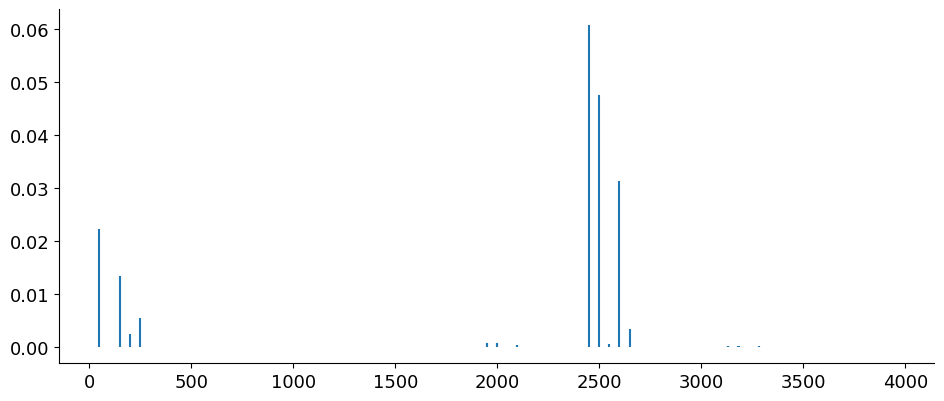

In [28]:
spec.plot(image_size=(700, 300))

# Analytic Models

We use these implicitly in the DGB and DVR examples

In [20]:
from Psience.AnalyticModels import *

# Experimental

## Di-iron nitrosyl Anion

In [3]:
Molecule = TestManager.import_from("Psience.Molecools", "Molecule")
anion_nitro = Molecule.from_file(
    Projects.test_data("2DIR", "freq_anion_12_11.fchk"),
    internals = {
        'primitives':'auto',
        'nonredundant_coordinates':[
            (4, 7),
            (5, 10),
            (6, 11),
            (4, 7, 0),
            (5, 10, 1),
            (6, 11, 1),
            (0, 7),
            (1, 10),
            (1, 11),
        ],
        'base_coords':[
            # (4, 7),
            # (5, 10),
            # (6, 11),
            # (4, 7, 0),
            # (5, 10, 1),
            # (6, 11, 1),
            # (0, 7),
            # (1, 10),
            # (1, 11),
            # (0, 10),
            (0, 1),
            (0, 2),
            (0, 3),
            (1, 2),
            (1, 3),
            (2, 0, 1, 3)
        ],
        # 'prune_coordinates':False
    }
)

In [8]:
anion_nitro.internal_coordinates.converter_options['redundant_transformation'].shape

(156, 108)

In [ ]:
anion_nitro.animate_coordinate(9)

In [10]:
interactive.FormattedTable(
    np.linalg.norm(anion_nitro.internal_coordinates.converter_options['redundant_transformation'], axis=1)[np.newaxis],
    column_formats="4.2f"
)

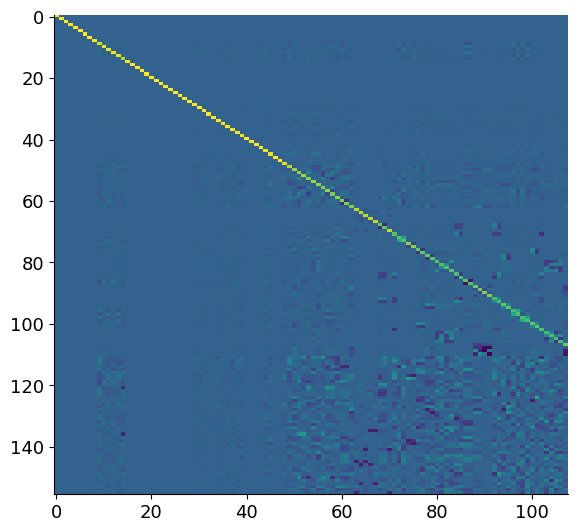

In [11]:
plt.ArrayPlot(anion_nitro.internal_coordinates.converter_options['redundant_transformation'])

In [ ]:
anion_nitro.animate_coordinate(92, mode='jsmol')

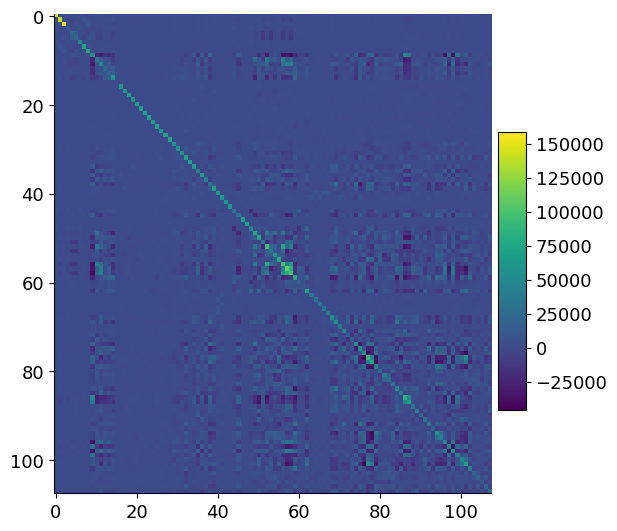

In [15]:
cart_conv = anion_nitro.get_cartesians_by_internals(2)
internal_tensors = nput.tensor_reexpand(cart_conv, [0, anion_nitro.potential_derivatives[1]])
plt.ArrayPlot(internal_tensors[1] * UnitsData.convert("Hartrees", "Wavenumbers"), colorbar=True)

In [ ]:
plt.ArrayPlot(internal_tensors[1][:3, 3:] * UnitsData.convert("Hartrees", "Wavenumbers"), colorbar=True, 
             image_size=(1000, 100))

In [ ]:
anion_nitro.animate_coordinate(58)

In [972]:
np.where(
    np.abs(internal_tensors[1][1]) 
    * UnitsData.convert("Hartrees", "Wavenumbers") > 2000
)

(array([ 1,  2,  7, 14, 50, 56, 58, 87]),)

In [17]:
interactive.FormattedTable(
    internal_tensors[1][(1,), 9:] * UnitsData.convert("Hartrees", "Wavenumbers")
)

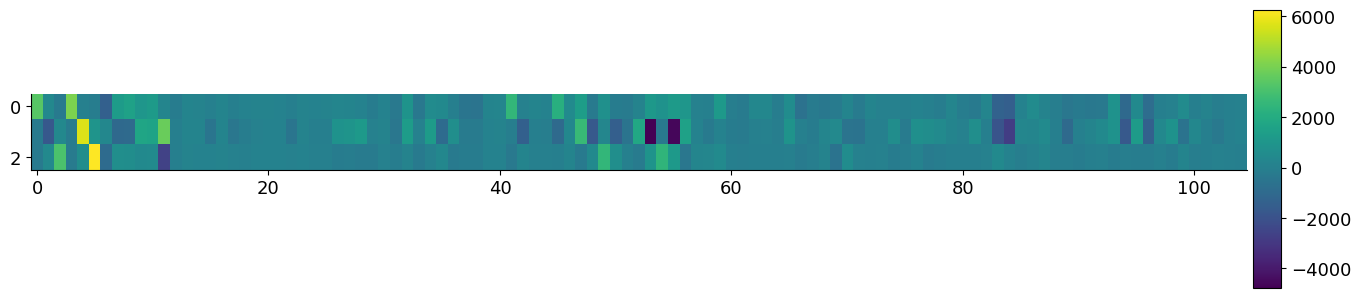

In [18]:
plt.ArrayPlot(internal_tensors[1][:3, 3:] * UnitsData.convert("Hartrees", "Wavenumbers"), colorbar=True, 
             image_size=(1000, 100))

In [19]:
interactive.FormattedTable(
    internal_tensors[1][:3, 3:] * UnitsData.convert("Hartrees", "Wavenumbers")
)